In [1]:
%cd ../..

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-


In [8]:
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm.autonotebook import tqdm
import os
import warnings
from pathlib import Path
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    ExponentialSmoothing,
    Theta, 
    FFT,
    LightGBMModel
)
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.metrics import mase
from src.utils.ts_utils import rmsse
import plotly.figure_factory as ff

np.random.seed()

In [4]:
os.makedirs("imgs/chapter_17", exist_ok=True)
preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")

In [5]:
from itertools import cycle
def format_plot(fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.9,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text=ylabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text=xlabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        )
    )
    return fig

In [7]:
def format_y_pred(y_pred, name):
    y_pred = y_pred.data_array().to_series()
    y_pred.index = y_pred.index.get_level_values(0)
    y_pred.name = name
    return y_pred

# Reading Files

In [6]:
#Readin the missing value imputed and train test split data
try:
    train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed.parquet")
    val_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed.parquet")
    test_df = pd.read_parquet(preprocessed/"selected_blocks_test_missing_imputed.parquet")
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 01-Setting up Experiment Harness.ipynb in Chapter04
    </div>
    """))

# Generating Forecasts

In [10]:
lcl_ids = sorted(train_df.LCLid.unique())

In [11]:
name = "Naive"
preds = []
metrics = []
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    for lcl_id in tqdm(lcl_ids):
        model = NaiveSeasonal(K=1)
        tr = TimeSeries.from_series(train_df.loc[train_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        vl = TimeSeries.from_series(val_df.loc[val_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        model.fit(tr)
        y_pred = model.predict(len(vl))
        _mase = mase(vl, y_pred, tr)
        _rmsse = rmsse(vl, y_pred, tr)
        y_pred = format_y_pred(y_pred, "predictions").to_frame()
        y_pred['LCLid'] = lcl_id
        y_pred['Algorithm'] = name
        y_pred['energy_consumption'] = vl.data_array().to_series().values
        metric_dict = dict()
        metric_dict["LCLid"] = lcl_id
        metric_dict['Algorithm'] = name
        metric_dict['MASE'] = _mase
        metric_dict['RMSSE'] = _rmsse
        preds.append(y_pred)
        metrics.append(metric_dict)

  0%|          | 0/150 [00:00<?, ?it/s]

In [12]:
name = "SeasonalNaive"
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    for lcl_id in tqdm(lcl_ids):
        model = NaiveSeasonal(K=48*7)
        tr = TimeSeries.from_series(train_df.loc[train_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        vl = TimeSeries.from_series(val_df.loc[val_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        model.fit(tr)
        y_pred = model.predict(len(vl))
        _mase = mase(vl, y_pred, tr)
        _rmsse = rmsse(vl, y_pred, tr)
        y_pred = format_y_pred(y_pred, "predictions").to_frame()
        y_pred['LCLid'] = lcl_id
        y_pred['Algorithm'] = name
        y_pred['energy_consumption'] = vl.data_array().to_series().values
        metric_dict = dict()
        metric_dict["LCLid"] = lcl_id
        metric_dict['Algorithm'] = name
        metric_dict['MASE'] = _mase
        metric_dict['RMSSE'] = _rmsse
        preds.append(y_pred)
        metrics.append(metric_dict)

  0%|          | 0/150 [00:00<?, ?it/s]

In [13]:
name = "Theta"
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    for lcl_id in tqdm(lcl_ids):
        model = Theta(theta=3, seasonality_period=48*7, season_mode=SeasonalityMode.ADDITIVE)
        tr = TimeSeries.from_series(train_df.loc[train_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        vl = TimeSeries.from_series(val_df.loc[val_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        model.fit(tr)
        y_pred = model.predict(len(vl))
        _mase = mase(vl, y_pred, tr)
        _rmsse = rmsse(vl, y_pred, tr)
        y_pred = format_y_pred(y_pred, "predictions").to_frame()
        y_pred['LCLid'] = lcl_id
        y_pred['Algorithm'] = name
        y_pred['energy_consumption'] = vl.data_array().to_series().values
        metric_dict = dict()
        metric_dict["LCLid"] = lcl_id
        metric_dict['Algorithm'] = name
        metric_dict['MASE'] = _mase
        metric_dict['RMSSE'] = _rmsse
        preds.append(y_pred)
        metrics.append(metric_dict)

  0%|          | 0/150 [00:00<?, ?it/s]

In [14]:
name = "FFT"
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    for lcl_id in tqdm(lcl_ids):
        model = FFT(nr_freqs_to_keep=35, trend="poly", trend_poly_degree=2)
        tr = TimeSeries.from_series(train_df.loc[train_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        vl = TimeSeries.from_series(val_df.loc[val_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        model.fit(tr)
        y_pred = model.predict(len(vl))
        _mase = mase(vl, y_pred, tr)
        _rmsse = rmsse(vl, y_pred, tr)
        y_pred = format_y_pred(y_pred, "predictions").to_frame()
        y_pred['LCLid'] = lcl_id
        y_pred['Algorithm'] = name
        y_pred['energy_consumption'] = vl.data_array().to_series().values
        metric_dict = dict()
        metric_dict["LCLid"] = lcl_id
        metric_dict['Algorithm'] = name
        metric_dict['MASE'] = _mase
        metric_dict['RMSSE'] = _rmsse
        preds.append(y_pred)
        metrics.append(metric_dict)

  0%|          | 0/150 [00:00<?, ?it/s]

In [15]:
name = "LightGBM"
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    for lcl_id in tqdm(lcl_ids):
        model = LightGBMModel(lags=[-1,-2,-3,-4,-5,-6,-48,-48*7], output_chunk_length=48)
        tr = TimeSeries.from_series(train_df.loc[train_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        vl = TimeSeries.from_series(val_df.loc[val_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        model.fit(tr)
        y_pred = model.predict(len(vl))
        _mase = mase(vl, y_pred, tr)
        _rmsse = rmsse(vl, y_pred, tr)
        y_pred = format_y_pred(y_pred, "predictions").to_frame()
        y_pred['LCLid'] = lcl_id
        y_pred['Algorithm'] = name
        y_pred['energy_consumption'] = vl.data_array().to_series().values
        metric_dict = dict()
        metric_dict["LCLid"] = lcl_id
        metric_dict['Algorithm'] = name
        metric_dict['MASE'] = _mase
        metric_dict['RMSSE'] = _rmsse
        preds.append(y_pred)
        metrics.append(metric_dict)

  0%|          | 0/150 [00:00<?, ?it/s]

In [16]:
name = "ETS"
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    for lcl_id in tqdm(lcl_ids):
        model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=True, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=48*7, random_state=42)
        tr = TimeSeries.from_series(train_df.loc[train_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        vl = TimeSeries.from_series(val_df.loc[val_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        model.fit(tr)
        y_pred = model.predict(len(vl))
        _mase = mase(vl, y_pred, tr)
        _rmsse = rmsse(vl, y_pred, tr)
        y_pred = format_y_pred(y_pred, "predictions").to_frame()
        y_pred['LCLid'] = lcl_id
        y_pred['Algorithm'] = name
        y_pred['energy_consumption'] = vl.data_array().to_series().values
        metric_dict = dict()
        metric_dict["LCLid"] = lcl_id
        metric_dict['Algorithm'] = name
        metric_dict['MASE'] = _mase
        metric_dict['RMSSE'] = _rmsse
        preds.append(y_pred)
        metrics.append(metric_dict)

  0%|          | 0/150 [00:00<?, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\M

In [17]:
pred_df = pd.concat(preds)
pred_df.head()

,predictions,LCLid,Algorithm,energy_consumption
timestamp,,,,
2014-01-01 00:00:00,0.179,MAC000061,Naive,0.165
2014-01-01 00:30:00,0.179,MAC000061,Naive,0.167
2014-01-01 01:00:00,0.179,MAC000061,Naive,0.150
2014-01-01 01:30:00,0.179,MAC000061,Naive,0.091
2014-01-01 02:00:00,0.179,MAC000061,Naive,0.047


In [18]:
pivot_df = pd.pivot_table(pred_df.reset_index(), index=["LCLid", "timestamp", "energy_consumption"], columns=['Algorithm'], values=['predictions'])
pivot_df.columns = pivot_df.columns.get_level_values(-1)
pivot_df = pivot_df.reset_index().set_index(['LCLid'])
pivot_df.head()

Algorithm,timestamp,energy_consumption,ETS,FFT,LightGBM,Naive,SeasonalNaive,Theta
LCLid,,,,,,,,
MAC000061,2014-01-01 00:00:00,0.165,0.158096,0.111663,0.142895,0.179,0.157,0.157925
MAC000061,2014-01-01 00:30:00,0.167,0.150456,0.088207,0.127311,0.179,0.083,0.150391
MAC000061,2014-01-01 01:00:00,0.150,0.147509,0.070980,0.095174,0.179,0.054,0.147510
MAC000061,2014-01-01 01:30:00,0.091,0.146653,0.060706,0.120303,0.179,0.053,0.146589
MAC000061,2014-01-01 02:00:00,0.047,0.147875,0.056753,0.094570,0.179,0.049,0.147600


In [36]:
metric_df = pd.DataFrame(metrics)
benchmark_metric_df = metric_df.loc[metric_df.Algorithm=="Naive",["LCLid",'MASE','RMSSE']].set_index("LCLid")
metric_df = metric_df.loc[metric_df.Algorithm!="Naive",["LCLid","Algorithm",'MASE','RMSSE']]
metric_df.set_index(["LCLid", "Algorithm"], inplace=True)
metric_df.head()

,,MASE,RMSSE
LCLid,Algorithm,,
MAC000061,SeasonalNaive,1.897168,1.529994
MAC000062,SeasonalNaive,1.528590,1.730176
MAC000066,SeasonalNaive,2.023330,1.585089
MAC000086,SeasonalNaive,1.836727,1.475517
MAC000126,SeasonalNaive,1.878985,1.795475


In [37]:
benchmark_metric_df.head()

,MASE,RMSSE
LCLid,,
MAC000061,2.583152,1.671148
MAC000062,3.834833,2.321079
MAC000066,1.899568,1.449708
MAC000086,1.715957,1.461549
MAC000126,2.340603,1.412106


In [38]:
pred_df.to_pickle(output/"preds_for_metric_analysis.pkl")
pivot_df.to_pickle(output/"pivoted_preds_for_metric_analysis.pkl")
metric_df.to_pickle(output/"metrics_for_metric_analysis.pkl")
benchmark_metric_df.to_pickle(output/"benchmark_metrics_for_metric_analysis.pkl")

## Metric Definitions

In [39]:
def geo_mean(iterable):
    a = np.array(iterable)
    a = a[~np.isnan(a)]
    return a.prod()**(1.0/len(a))

def geo_mean_overflow(iterable):
    return np.exp(np.log(iterable).mean())

In [40]:
def clean_inf(array):
    array[np.isinf(array)] = np.nan
    return array

In [41]:
#MAPE
def calc_mape(df, fc_col, ac_col, benchmark_col=None):
    a = df[ac_col].values
    f = df[fc_col].values
    abs_err = np.abs(a-f)
    ape = clean_inf(abs_err/a)
    return np.nanmean(ape)

#WAPE
def calc_wape(df, fc_col, ac_col, benchmark_col=None):
    a = df[ac_col].values
    f = df[fc_col].values
    abs_err = np.abs(a-f)
    return np.sum(abs_err)/np.sum(np.abs(a))

#sMAPE
def calc_smape(df, fc_col, ac_col, benchmark_col=None):
    a = df[ac_col].values
    f = df[fc_col].values
    abs_err = np.abs(a-f)
    ape = 2*abs_err/(a+f)
    return np.mean(ape)

#MAE
def calc_mae(df, fc_col, ac_col, benchmark_col=None):
    a = df[ac_col].values
    f = df[fc_col].values
    abs_err = np.abs(a-f)
    return np.mean(abs_err)

#MdAE
def calc_mdae(df, fc_col, ac_col, benchmark_col=None):
    a = df[ac_col].values
    f = df[fc_col].values
    abs_err = np.abs(a-f)
    return np.median(abs_err)

#GMAE
def calc_gmae(df, fc_col, ac_col, benchmark_col=None):
    a = df[ac_col].values
    f = df[fc_col].values
    abs_err = np.abs(a-f)
    return geo_mean(abs_err)

#MSE
def calc_mse(df, fc_col, ac_col, benchmark_col=None):
    a = df[ac_col].values
    f = df[fc_col].values
    sq_err = np.power(np.abs(a-f),2)
    return np.mean(sq_err)


#RMSE
def calc_rmse(df, fc_col, ac_col, benchmark_col=None):
    a = df[ac_col].values
    f = df[fc_col].values
    sq_err = np.power(np.abs(a-f),2)
    return np.sqrt(np.mean(sq_err))

#MRAE
def calc_mrae(df, fc_col, ac_col, benchmark_col):
    a = df[ac_col].values
    f = df[fc_col].values
    f_star = df[benchmark_col].values
    abs_err = np.abs(a-f)
    ape = clean_inf(abs_err/np.abs((a-f_star)))
    return np.nanmean(ape)

#GMRAE
def calc_gmrae(df, fc_col, ac_col, benchmark_col):
    a = df[ac_col].values
    f = df[fc_col].values
    f_star = df[benchmark_col].values
    abs_err = np.abs(a-f)
    ape = clean_inf(abs_err/np.abs((a-f_star)))
    return geo_mean(ape)

#MdRAE
def calc_mdrae(df, fc_col, ac_col, benchmark_col):
    a = df[ac_col].values
    f = df[fc_col].values
    f_star = df[benchmark_col].values
    abs_err = np.abs(a-f)
    ape = clean_inf(abs_err/np.abs((a-f_star)))
    return np.nanmedian(ape)

# #MASE
# def calc_mase(df, fc_col, ac_col, benchmark_col):
#     a = df[ac_col].values[1:]
#     f = df[fc_col].values[1:]
#     f_star = df[ac_col].shift(1).values[1:]
#     abs_err = np.abs(a-f)
#     ape = abs_err/np.mean(np.abs(a-f_star))
#     return np.mean(ape)

# # RMSSE
# def calc_rmsse(df, fc_col, ac_col):
#     a = df[ac_col].values[1:]
#     f = df[fc_col].values[1:]
#     f_star = df[ac_col].shift(1).values[1:]
#     sq_err = np.square(a-f)
#     scale = np.mean(np.square(a-f_star))
#     return np.sqrt(np.mean(sq_err/scale))

#RelMAE
def calc_rmae(df, fc_col, ac_col, benchmark_col):
    a = df[ac_col].values
    f = df[fc_col].values
    f_star = df[benchmark_col].values
    abs_err = np.abs(a-f)
    abs_err_star = np.abs(a-f_star)
    return np.mean(abs_err)/np.mean(abs_err_star)

#RelRMSE
def calc_rrmse(df, fc_col, ac_col, benchmark_col):
    a = df[ac_col].values
    f = df[fc_col].values
    f_star = df[benchmark_col].values
    sq_err = np.square(a-f)
    sq_err_star = np.square(a-f_star)
    return np.sqrt(np.mean(sq_err))/np.sqrt(np.mean(sq_err_star))

#RelMAPE
def calc_rmape(df, fc_col, ac_col, benchmark_col):
    a = df[ac_col].values
    f = df[fc_col].values
    f_star = df[benchmark_col].values
    perc_err = clean_inf(np.abs(a-f)/a)
    perc_err_star = clean_inf(np.abs(a-f_star)/a)
    return np.nanmean(perc_err)/np.nanmean(perc_err_star)

#CFE
def calc_cfe(df, fc_col, ac_col, benchmark_col=None):
    a = df[ac_col].values
    f = df[fc_col].values
    err = a-f
    return np.sum(err)

#FB
def calc_fb(df, fc_col, ac_col, benchmark_col=None):
    a = df[ac_col].values
    f = df[fc_col].values
    err = a-f
    return np.sum(err)/np.sum(a)

#PB
def calc_pbmae(df, fc_col, ac_col, benchmark_col=None):
    a = df[ac_col].values
    f = df[fc_col].values
    f_star = df[benchmark_col].values
    abs_err = np.abs(a-f)
    abs_err_star = np.abs(a-f_star)
    # mae_star = np.mean(abs_err_star)
    # mae = np.mean(abs_err)
    mask = abs_err<abs_err_star
    return np.sum(mask)/len(mask)

## Calculating Item-Level Metrics

In [42]:
fns = {
    "MAPE": calc_mape,
    "WAPE": calc_wape,
    "sMAPE": calc_smape,
    "MAE": calc_mae,
    "MdAE" : calc_mdae,
    # "GMAE": calc_gmae,
    "MSE": calc_mse,
    "RMSE": calc_rmse,
    "MRAE": calc_mrae,
    # "GMRAE": calc_gmrae,
    # "RMSSE": calc_rmsse,
    "RelMAE": calc_rmae,
    "RelRMSE": calc_rrmse,
    "RelMAPE": calc_rmape,
    "CFE": calc_cfe,
    "FB" : calc_fb,
    "PB(MAE)": calc_pbmae
}

fcs = metric_df.reset_index()["Algorithm"].unique()

In [43]:
for lcl_id in tqdm(lcl_ids):
    df = pivot_df.xs(lcl_id)
    for metric, fn in fns.items():
        for fc in fcs:
            metric_df.loc[(lcl_id,fc), metric] = fn(df, fc, "energy_consumption", "Naive")

  0%|          | 0/150 [00:00<?, ?it/s]

C:\Users\ManuJoseph\AppData\Local\Temp\ipykernel_56272\1128455912.py:66: RuntimeWarning: divide by zero encountered in true_divide
  ape = clean_inf(abs_err/np.abs((a-f_star)))
C:\Users\ManuJoseph\AppData\Local\Temp\ipykernel_56272\1128455912.py:66: RuntimeWarning: divide by zero encountered in true_divide
  ape = clean_inf(abs_err/np.abs((a-f_star)))
C:\Users\ManuJoseph\AppData\Local\Temp\ipykernel_56272\1128455912.py:66: RuntimeWarning: divide by zero encountered in true_divide
  ape = clean_inf(abs_err/np.abs((a-f_star)))
C:\Users\ManuJoseph\AppData\Local\Temp\ipykernel_56272\1128455912.py:6: RuntimeWarning: divide by zero encountered in true_divide
  ape = clean_inf(abs_err/a)
C:\Users\ManuJoseph\AppData\Local\Temp\ipykernel_56272\1128455912.py:128: RuntimeWarning: divide by zero encountered in true_divide
  perc_err = clean_inf(np.abs(a-f)/a)
C:\Users\ManuJoseph\AppData\Local\Temp\ipykernel_56272\1128455912.py:129: RuntimeWarning: divide by zero encountered in true_divide
  perc_e

In [44]:
metric_df

,,MASE,RMSSE,MAPE,WAPE,sMAPE,MAE,MdAE,MSE,RMSE,MRAE,RelMAE,RelRMSE,RelMAPE,CFE,FB,PB(MAE)
LCLid,Algorithm,,,,,,,,,,,,,,,,
MAC000061,SeasonalNaive,1.897168,1.529994,0.951624,0.530025,0.541489,0.066293,0.040000,0.009415,0.097029,2.773427,0.734439,0.915535,0.451851,-7.448000,-0.040019,0.605511
MAC000062,SeasonalNaive,1.528590,1.730176,0.417136,0.428145,0.326829,0.115088,0.053000,0.054056,0.232500,0.694436,0.398607,0.745419,0.319750,-20.757000,-0.051895,0.878360
MAC000066,SeasonalNaive,2.023330,1.585089,0.863568,0.483872,0.441342,0.078139,0.038000,0.021352,0.146122,2.311459,1.065153,1.093385,1.035467,-30.640999,-0.127515,0.551075
MAC000086,SeasonalNaive,1.836727,1.475517,1.791734,0.905448,0.810602,0.157860,0.108500,0.048209,0.219566,6.704939,1.070380,1.009558,2.702580,-26.433000,-0.101891,0.557796
MAC000126,SeasonalNaive,1.878985,1.795475,1.922482,0.970257,0.777872,0.123932,0.047000,0.059956,0.244860,2.075620,0.802778,1.271487,0.410881,-8.808999,-0.046348,0.706989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAC005336,ETS,2.916418,1.809797,1.691181,0.638176,0.773611,0.260747,0.112325,0.211541,0.459935,1.046477,0.686529,0.620530,1.033327,206.980151,0.340445,0.569220
MAC005375,ETS,4.412716,2.799472,0.867657,0.889136,1.710135,0.241380,0.153995,0.136372,0.369285,2.439134,1.168561,1.060955,1.436400,354.501549,0.877570,0.241935
MAC005463,ETS,3.659451,1.860985,4.817678,1.792612,1.150070,0.206756,0.203729,0.050053,0.223724,1.941704,1.124312,1.099837,1.060664,-273.806698,-1.595396,0.467070


## Calculating Aggregate Metrics

In [197]:
def calc_nd(df, fc_col, ac_col, benchmark_col=None):
    a = df[ac_col].values
    f = df[fc_col].values
    abs_err = np.abs(a-f)
    return np.sum(abs_err)/np.sum(np.abs(a))

def calc_nrmse(df, fc_col, ac_col, benchmark_col=None):
    a = df[ac_col].values
    f = df[fc_col].values
    sq_err = np.square(a-f)
    return np.sum(sq_err)/np.sum(np.square(a))

def calc_forecast_bias(df, fc_col, ac_col, benchmark_col=None):
    a = df[ac_col].values
    f = df[fc_col].values
    err = a-f
    return np.sum(err)/np.sum(a)

In [198]:
agg_metrics = []
for fc in fcs:
    met_dict = {
        "Algorithm": fc,
        "meanMASE": metric_df.xs(fc, level=1)["MASE"].mean(), 
        "meanRMSSE": metric_df.xs(fc, level=1)["RMSSE"].mean(), 
        "meanWAPE":  metric_df.xs(fc, level=1)["WAPE"].mean(),
        "meanMRAE": metric_df.xs(fc, level=1)["MRAE"].mean(),
        "AvgRelRMSE": geo_mean(clean_inf(metric_df.xs(fc, level=1)["RelRMSE"].values)),
        "ND": calc_nd(pivot_df, fc_col = fc, ac_col="energy_consumption"),
        "NRMSE": calc_nrmse(pivot_df, fc_col = fc, ac_col="energy_consumption"),
        "Forecast Bias": calc_forecast_bias(pivot_df, fc_col = fc, ac_col="energy_consumption"),
    }
    agg_metrics.append(met_dict)

In [199]:
agg_metrics_df = pd.DataFrame(agg_metrics)
agg_metrics_df

,Algorithm,meanMASE,meanRMSSE,meanWAPE,meanMRAE,AvgRelRMSE,ND,NRMSE,Forecast Bias
0,SeasonalNaive,1.875866,1.562892,0.672265,3.401273,0.000000,0.667409,0.615014,0.008958
1,Theta,2.025960,1.350071,0.709430,3.230300,0.844399,0.683573,0.480506,-0.019637
2,FFT,1.639406,1.205949,0.565284,3.447706,0.792171,0.550400,0.390569,0.135705
3,LightGBM,1.868580,1.339632,0.699452,4.711123,0.869761,0.669670,0.505878,-0.005706
4,ETS,2.012408,1.335142,0.703046,3.375641,0.754607,0.683709,0.471532,-0.007773


## Ranking and Plotting Aggregate Metrics

In [200]:
# Ranking each algorithm based on different metrics
rank_df = agg_metrics_df.copy()
cols = agg_metrics_df.columns.tolist()
cols.remove("Algorithm")
for col in cols:
    rank_df[col] = rank_df[col].rank(ascending=True)
rank_df.head()

,Algorithm,meanMASE,meanRMSSE,meanWAPE,meanMRAE,AvgRelRMSE,ND,NRMSE,Forecast Bias
0,SeasonalNaive,3.0,5.0,2.0,3.0,1.0,2.0,5.0,4.0
1,Theta,5.0,4.0,5.0,1.0,4.0,4.0,3.0,1.0
2,FFT,1.0,1.0,1.0,4.0,3.0,1.0,1.0,5.0
3,LightGBM,2.0,3.0,3.0,5.0,5.0,3.0,4.0,3.0
4,ETS,4.0,2.0,4.0,2.0,2.0,5.0,2.0,2.0


In [203]:
cols = ["meanMASE", "meanWAPE", "ND", "meanRMSSE", "NRMSE", "meanMRAE", "Forecast Bias","AvgRelRMSE"]

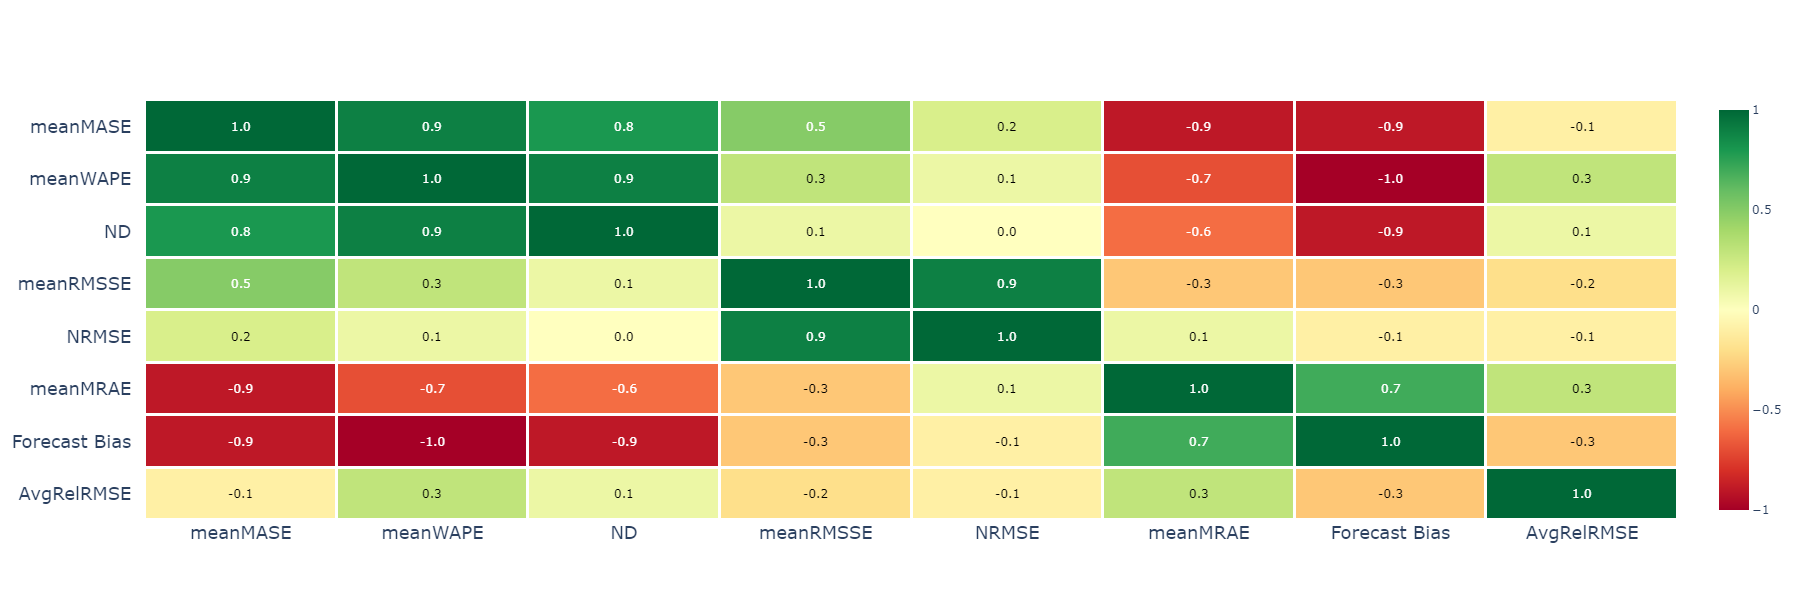

In [204]:
#Plotting an annotated heatmap
font_size = 18
corr_df = rank_df[cols].corr(method="pearson")
# to mask upper triangle
# mask = np.triu(np.ones_like(corr_df, dtype=np.bool))
# corr_df = corr_df.mask(mask)

fig = ff.create_annotated_heatmap(
    z=corr_df.to_numpy().round(2),
    x=list(corr_df.index.values),
    y=list(corr_df.columns.values),
    xgap=3,
    ygap=3,
    zmin=-1,
    zmax=1,
    colorscale="RdYlGn",
    showscale=True,
    colorbar_thickness=30,
    colorbar_ticklen=3,
)
fig.update_layout(
    # title_text="Spearman's Correlation between <br> Aggregate Rankings of Forecast Methods",
    title_x=0.5,
    titlefont={"size": 24},
    width=600,
    height=600,
    xaxis_showgrid=False,
    xaxis={"side": "bottom", "tickfont":dict(size=font_size)},
    yaxis_showgrid=False,
    yaxis_autorange="reversed",
    template="plotly_white",
    yaxis=dict(
        tickfont=dict(size=font_size),
    ))
# NaN values are not handled automatically and are displayed in the figure
# So we need to get rid of the text manually
# Also annotation color needs to be switched to black when value is less than 0,5
# for better visibility
for i in range(len(fig.layout.annotations)):
    if fig.layout.annotations[i].text == "nan":
        fig.layout.annotations[i].text = ""
    try:
        annot = float(fig.layout.annotations[i].text)
        if abs(annot) < 0.5:
            fig.layout.annotations[i].font = {"color": "#000000"}
    except ValueError:
        pass
fig.write_image(f"imgs/chapter_17/aggregate_metric_correlation.png")
fig.show()

## Ranking and Plotting Item Level Metrics

In [209]:
# Calculating rank of households based on each metric for every algorithm
def calc_rank(rank_df):
    for col in metric_df.columns:
        rank_df[col] = rank_df[col].rank(ascending=True)

    for col in ['PB(MAE)']:
        rank_df[col] = rank_df[col].rank(ascending=False)

    for col in ['CFE', 'FB']:
        rank_df[col] = np.abs(rank_df[col]).rank(ascending=True)
    return rank_df

item_rankings =metric_df.groupby('Algorithm').apply(calc_rank)

In [210]:
cols = [
    "MASE",
    "RMSSE",
    "MAPE",
    "WAPE",
    "sMAPE",
    "MAE",
    "MdAE",
    "MSE",
    "RMSE",
    "MRAE",
    "RelMAE",
    "RelRMSE",
    "RelMAPE",
    "PB(MAE)",
    "CFE",
    "FB",
]

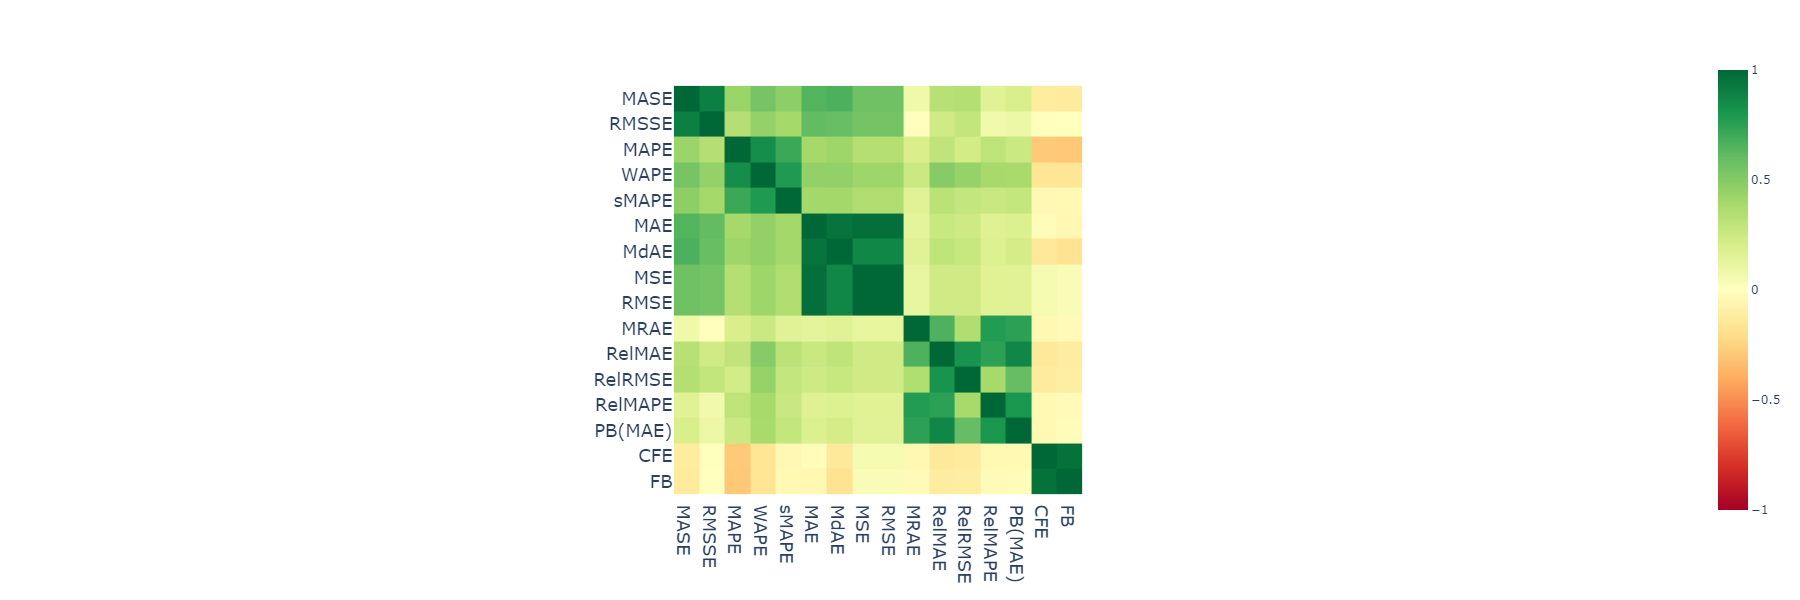

In [211]:
corr_df = item_rankings[cols].corr(method='pearson')
# to mask upper triangle
# mask = np.triu(np.ones_like(corr_df, dtype=np.bool))
# corr_df = corr_df.mask(mask)
fig = px.imshow(corr_df, template="plotly_white", color_continuous_scale="RdYlGn", range_color=[-1,1])
fig.update_layout(
    # title_text="Spearman's Correlation between <br> Aggregate Rankings of Forecast Methods",
    # title_x=0.5,
    # titlefont={"size": 24},
    width=600,
    height=600,
    xaxis_showgrid=False,
    xaxis={"side": "bottom", "tickfont":dict(size=font_size)},
    yaxis_showgrid=False,
    yaxis_autorange="reversed",
    template="plotly_white",
    yaxis=dict(
        tickfont=dict(size=font_size),
    ))
fig.write_image(f"imgs/chapter_17/item_lvl_metric_correlation.png")
fig.show()